# Water Quality 

**What does this notebook do?** This notebook steps you through how to load in and plot up data from Sentinel 2. It explores the data that are available from the Sentinel 2 satellite, and briefly describes the Sentinel satellite bands. It then loads in the `s2a_ard_granule` product and plots it up in true and false colour. It uses the provided pixel quality data to filters the example scene based on `cloud` and `cloud shadow`-free pixels. 

**Before you run this notebook:** You need to run the following commands from the command line prior to launching jupyter notebook from the same terminal so that the required libraries and paths are set.

`module use /g/data/v10/public/modules/modulefiles`

`module load dea`

**Date**: November 2018

**Author**: Claire Krause, Robbi Bishop-Taylor

In [24]:
%pylab notebook

from datacube.storage import masking
from datacube import Datacube
from datacube.utils import geometry
from datacube.utils.geometry import CRS
from datetime import datetime
from skimage import exposure
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
# Import widgets for interactive notebook
from ipywidgets import interact, fixed
import ipywidgets as widgets

# Point this to where you have the algorithms from the dea-notebooks/algorithms saved
sys.path.append(os.path.abspath('/home/151/jh8194/dea-notebooks/10_Scripts'))
import DEAPlotting
import DEADataHandling

# Connect to datacube
# The path to the Sentinel 2 development DEA instance configuration file
dc = Datacube(app='Sentinel2 spectra')


Populating the interactive namespace from numpy and matplotlib


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['exp']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


**Define the function in order to select a pixel and develop a spectral plot for the image**

Taken from DEA-notebook

***Yarrawonga Site***
-36.0114	145.994

### Selecting the site that we want
- in order to identify the site that is wanted for this anaylsis we are going to identify the site of Yarrawonga and create a buffer around the site. This code also allows for a re-scale, from the Band5 (20m) to a 10m resolution

In [25]:
# Set up centre of area to analyse, and a buffer in metres around this centrepoint
lat, lon, buffer_m = -36.0114, 145.9940, 250

# Set range of time to return data from both Landsat and Sentinel 2
time_range = ('2015-01-01', '2017-12-01')

# Set the output resolution for both datasets. (-10, 10) will resample the Sentinel2 Band 5 from 20m to the 10m resolution
resolution = (-10, 10)

# Set up minimum proportions of cloud-free pixels required to return Landsat and Sentinel2 observations.
# A proportion of 0.95 means that only observations with less than 5% cloud will be returned. Note that
# the Sentinel 2 cloud mask is often more aggressive, and sometimes requires a lower threshold
sentinel_goodquality_prop = 0.40


In [26]:
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer_m, x + buffer_m),
         'y': (y - buffer_m, y + buffer_m),
         'time': time_range,
         'crs': 'EPSG:3577',
         'output_crs': 'EPSG:3577',
         'resolution': resolution}

In [27]:
#query = {
#        'lat': (-35.95, -36.05),
#        'lon': (145.70, 146.30),
#        'output_crs': 'EPSG:3577',
#        'resolution': (-20, 20),
#        'time': ('2015-01-01', '2017-02-01')
#        }

Yarrawonga = DEADataHandling.load_clearsentinel2(dc=dc,query=query,sensors=['s2a','s2b'], 
                                                 bands_of_interest=('nbar_coastal_aerosol','nbar_red', 'nbar_green', 'nbar_blue','nbar_red_edge_1', 
                                                                    'nbar_red_edge_2','nbar_red_edge_3','nbar_nir_1','nbar_nir_2'),
                                                 masked_prop=sentinel_goodquality_prop, satellite_metadata=True)

Loading s2a pixel quality
    Loading 30 filtered s2a timesteps
Loading s2b pixel quality
    Loading 8 filtered s2b timesteps
Combining and sorting s2a, s2b data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


<xarray.Dataset>
Dimensions:               (time: 38, x: 50, y: 50)
Coordinates:
  * y                     (y) float64 -4.003e+06 -4.003e+06 ... -4.004e+06
  * x                     (x) float64 1.259e+06 1.259e+06 ... 1.259e+06
  * time                  (time) datetime64[ns] 2015-11-18T00:17:22.031000 ... 2017-11-24T00:11:11.026000
Data variables:
    nbar_coastal_aerosol  (time, y, x) float64 386.0 386.0 ... 1.021e+03
    nbar_red              (time, y, x) float64 520.0 521.0 537.0 ... 841.0 802.0
    nbar_green            (time, y, x) float64 476.0 493.0 513.0 ... 900.0 904.0
    nbar_blue             (time, y, x) float64 352.0 344.0 335.0 ... 683.0 619.0
    nbar_red_edge_1       (time, y, x) float64 981.0 981.0 ... 1.478e+03
    nbar_red_edge_2       (time, y, x) float64 1.819e+03 1.819e+03 ... 2.754e+03
    nbar_red_edge_3       (time, y, x) float64 2.125e+03 2.125e+03 ... 3.244e+03
    nbar_nir_1            (time, y, x) float64 2.294e+03 2.355e+03 ... 4.013e+03
    nbar_nir_2    

<IPython.core.display.Javascript object>


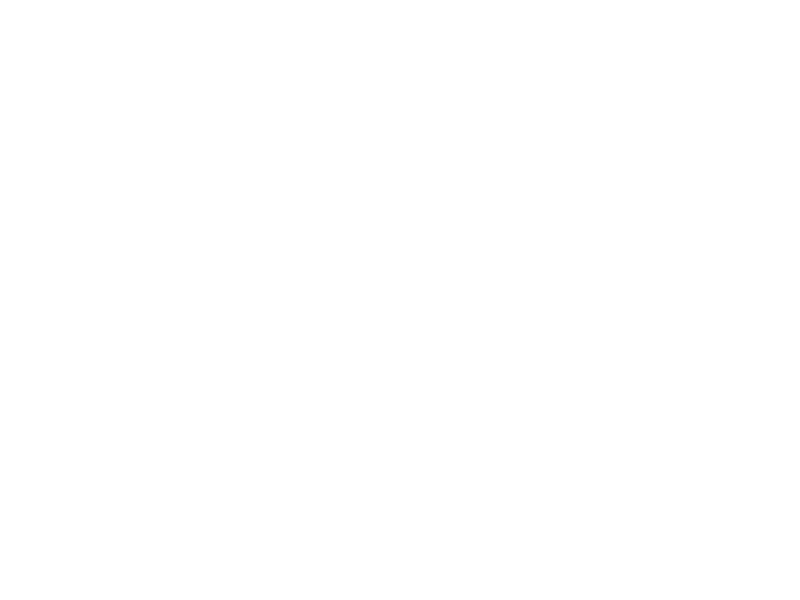

In [28]:
print(Yarrawonga)
DEAPlotting.rgb(Yarrawonga, bands=['nbar_red', 'nbar_green', 'nbar_blue'], index=2)
#Yarrawonga[['nbart_red', 'nbart_green', 'nbart_blue']].isel(time=range(0,1)).to_array().plot.imshow(robust=True, col='time')

In [29]:
#Yarrawonga.nbar_blue.isel(time=1).values

In [30]:
# pretty_names = {'s2a': 'Sentinel 2A', 's2b': 'Sentinel 2B'}
# satellite_names = [pretty_names[i] for i in Yarrawonga.satellite.values]

# # Produce an RGB animation that includes both Sentinel and Landsat observations, using
# # the `title` parameter to print satellite names for each observation
# DEAPlotting.animated_timeseries(ds=Yarrawonga,
#                                 output_path='Yarrawonga_Sentinel2.gif',
#                                 bands=['nbart_red', 'nbart_green', 'nbart_blue'],
#                                 interval=200,
#                                 width_pixels=500,
#                                 title=satellite_names,
#                                 percentile_stretch=[0.01, 0.99])

In [31]:
#Yarrawonga.time

### Identifying the spectral plots of the different satellite images

**using the code identified in the DEAnotebook**

In [58]:
%pylab notebook

# def onclick(event):
#     '''
#     This function performs all of the work in this notebook. We have put all of the
#     processing within this function so that all the calculations are done following
#     a 'click' and therefore do not need to be in separate cells. This makes the notebook
#     smoother and minimises the cells that need to be manually run by the user once a
#     location has been selected.

#     This particular widget function uses the selected to location to plot two images:
#     - spectra for the pixel closest to the chosen location
#     - spectra for the pixel/s closest to the chosen location using the 60m pixel as
#     a bounding box for the higher resolution pixels.
#     These two images are run in the subsequent cells.
#     '''
#     global pixelx, pixely, spectra, spectramin, spectramax, spectramean
#     pixelx, pixely = int(event.xdata), int(event.ydata)
#     w.value = 'pixelx : {}, pixely : {}'.format(pixelx, pixely)
#     plt.plot(pixelx, pixely, 'ro', markersize=5)
    
#     Resolution10m=Yarrawonga

#     # Find the pixel closest to the chosen pixel at each resolution
#     Pixel10m = Resolution10m.sel(y=pixely, x=pixelx, method='nearest')


#     # Grab the pixel spectral values for each band
#     spectra = [Pixel10m.nbar_blue.isel(time=mytime).values,
#                Pixel10m.nbar_green.isel(time=mytime).values,
#                Pixel10m.nbar_red.isel(time=mytime).values,
#                Pixel10m.nbar_red_edge_1.isel(time=mytime).values,
#                Pixel10m.nbar_nir_1.isel(time=mytime).values,
#                ]

#     # Get the location of the selected pixel at the coursest resolution
#     Pixel10m = Resolution10m.sel(y=pixely, x=pixelx, method='nearest')

#     # Find the index locations of the lat/lon of that pixel
#     xindex = Resolution10m.indexes['x'].get_loc(
#         Pixel10m.x.values.item(), method='nearest')
#     yindex = Resolution10m.indexes['y'].get_loc(
#         Pixel10m.y.values.item(), method='nearest')

#     # Get the index for the pixels next to the chosen pixel
#     xmax = Resolution10m.x.isel(x=xindex+2)
#     xmin = Resolution10m.x.isel(x=xindex-2)
#     ymax = Resolution10m.y.isel(y=yindex-2)
#     ymin = Resolution10m.y.isel(y=yindex+2)

#     # Now work out what the lat/lon is for halfway between pixel +-1 (to keep our resolution at 60 x 60 m)
#     latmin = mean((xmin, pixelx))
#     latmax = mean((pixelx, xmax))
#     lonmin = mean((ymin, pixely))
#     lonmax = mean((pixely, ymax))


#     # Grab all of the pixels that fall within the 60m pixel bounds
#     bluepixels = Resolution10m.nbar_blue.sel(
#         x=slice(latmin, latmax), y=slice(lonmax, lonmin))
#     greenpixels = Resolution10m.nbar_green.sel(
#         x=slice(latmin, latmax), y=slice(lonmax, lonmin))
#     redpixels = Resolution10m.nbar_red.sel(
#         x=slice(latmin, latmax), y=slice(lonmax, lonmin))
#     rededge1pixels = Resolution10m.nbar_red_edge_1.sel(
#         x=slice(latmin, latmax), y=slice(lonmax, lonmin))
#     nir1pixels = Resolution10m.nbar_nir_1.sel(
#         x=slice(latmin, latmax), y=slice(lonmax, lonmin))


#     # Grab the min, max and mean of the pixels within the 60m bounding box
#     spectramin = [bluepixels.isel(time=mytime).min().item(),
#                   greenpixels.isel(time=mytime).min().item(),
#                   redpixels.isel(time=mytime).min().item(),
#                   rededge1pixels.isel(time=mytime).min().item(),
#                   nir1pixels.isel(time=mytime).min().item(),
#                   ]

#     spectramax = [bluepixels.isel(time=mytime).max().item(),
#                   greenpixels.isel(time=mytime).max().item(),
#                   redpixels.isel(time=mytime).max().item(),
#                   rededge1pixels.isel(time=mytime).max().item(),
#                   nir1pixels.isel(time=mytime).max().item(),
#                   ]

#     spectramean = [bluepixels.isel(time=mytime).mean().item(),
#                    greenpixels.isel(time=mytime).mean().item(),
#                    redpixels.isel(time=mytime).mean().item(),
#                    rededge1pixels.isel(time=mytime).mean().item(),
#                    nir1pixels.isel(time=mytime).mean().item(),
#                   ]
    
def onclick(event):
    '''
    This function performs all of the work in this notebook. We have put all of the
    processing within this function so that all the calculations are done following
    a 'click' and therefore do not need to be in separate cells. This makes the notebook
    smoother and minimises the cells that need to be manually run by the user once a
    location has been selected.

    This particular widget function uses the selected to location to plot two images:
    - spectra for the pixel closest to the chosen location
    - spectra for the pixel/s closest to the chosen location using the 60m pixel as
    a bounding box for the higher resolution pixels.
    These two images are run in the subsequent cells.
    '''
    Resolution10m=Yarrawonga
    
    global pixelx, pixely, spectra, spectramin, spectramax, spectramean
    pixelx, pixely = int(event.xdata), int(event.ydata)
    w.value = 'pixelx : {}, pixely : {}'.format(pixelx, pixely)
    plt.plot(pixelx, pixely, 'ro', markersize=5)

    # Find the pixel closest to the chosen pixel at each resolution
    Pixel10m = Resolution10m.sel(y=pixely, x=pixelx, method='nearest')

    # Grab the pixel spectral values for each band
    spectra = [Pixel10m.nbar_coastal_aerosol.isel(time=mytime).values,
               Pixel10m.nbar_blue.isel(time=mytime).values,
               Pixel10m.nbar_green.isel(time=mytime).values,
               Pixel10m.nbar_red.isel(time=mytime).values,
               Pixel10m.nbar_red_edge_1.isel(time=mytime).values,
               Pixel10m.nbar_red_edge_2.isel(time=mytime).values,
               Pixel10m.nbar_red_edge_3.isel(time=mytime).values,
               Pixel10m.nbar_nir_1.isel(time=mytime).values,
               Pixel10m.nbar_nir_2.isel(time=mytime).values,
               ]

    # Get the location of the selected pixel at the coursest resolution
    Pixel10m = Resolution10m.sel(y=pixely, x=pixelx, method='nearest')

    # Find the index locations of the lat/lon of that pixel
    xindex = Resolution10m.indexes['x'].get_loc(
        Pixel10m.x.values.item(), method='nearest')
    yindex = Resolution10m.indexes['y'].get_loc(
        Pixel10m.y.values.item(), method='nearest')

    # Get the index for the pixels next to the chosen pixel
    xmax = Resolution10m.x.isel(x=xindex+1)
    xmin = Resolution10m.x.isel(x=xindex-1)
    ymax = Resolution10m.y.isel(y=yindex-1)
    ymin = Resolution10m.y.isel(y=yindex+1)

    # Now work out what the lat/lon is for halfway between pixel +-1 (to keep our resolution at 60 x 60 m)
    latmin = mean((xmin, pixelx))
    latmax = mean((pixelx, xmax))
    lonmin = mean((ymin, pixely))
    lonmax = mean((pixely, ymax))

    # Grab all of the pixels that fall within the 60m pixel bounds
    bluepixels = Resolution10m.nbar_blue.sel(
        x=slice(latmin, latmax), y=slice(lonmax, lonmin))
    greenpixels = Resolution10m.nbar_green.sel(
        x=slice(latmin, latmax), y=slice(lonmax, lonmin))
    redpixels = Resolution10m.nbar_red.sel(
        x=slice(latmin, latmax), y=slice(lonmax, lonmin))
    rededge1pixels = Resolution10m.nbar_red_edge_1.sel(
        x=slice(latmin, latmax), y=slice(lonmax, lonmin))
    rededge2pixels = Resolution10m.nbar_red_edge_2.sel(
        x=slice(latmin, latmax), y=slice(lonmax, lonmin))
    rededge3pixels = Resolution10m.nbar_red_edge_3.sel(
        x=slice(latmin, latmax), y=slice(lonmax, lonmin))
    nir1pixels = Resolution10m.nbar_nir_1.sel(
        x=slice(latmin, latmax), y=slice(lonmax, lonmin))
    nir2pixels = Resolution10m.nbar_nir_2.sel(
        x=slice(latmin, latmax), y=slice(lonmax, lonmin))


    # Grab the min, max and mean of the pixels within the 60m bounding box
    spectramin = [Pixel10m.nbar_coastal_aerosol.isel(time=mytime).min().item(),
                  bluepixels.isel(time=mytime).min().item(),
                  greenpixels.isel(time=mytime).min().item(),
                  redpixels.isel(time=mytime).min().item(),
                  rededge1pixels.isel(time=mytime).min().item(),
                  rededge2pixels.isel(time=mytime).min().item(),
                  rededge3pixels.isel(time=mytime).min().item(),
                  nir1pixels.isel(time=mytime).min().item(),
                  nir2pixels.isel(time=mytime).min().item(),
                  ]

    spectramax = [Pixel10m.nbar_coastal_aerosol.isel(time=mytime).max().item(),
                  bluepixels.isel(time=mytime).max().item(),
                  greenpixels.isel(time=mytime).max().item(),
                  redpixels.isel(time=mytime).max().item(),
                  rededge1pixels.isel(time=mytime).max().item(),
                  rededge2pixels.isel(time=mytime).max().item(),
                  rededge3pixels.isel(time=mytime).max().item(),
                  nir1pixels.isel(time=mytime).max().item(),
                  nir2pixels.isel(time=mytime).max().item(),
                  ]

    spectramean = [Pixel10m.nbar_coastal_aerosol.isel(time=mytime).mean().item(),
                   bluepixels.isel(time=mytime).mean().item(),
                   greenpixels.isel(time=mytime).mean().item(),
                   redpixels.isel(time=mytime).mean().item(),
                   rededge1pixels.isel(time=mytime).mean().item(),
                   rededge2pixels.isel(time=mytime).mean().item(),
                   rededge3pixels.isel(time=mytime).mean().item(),
                   nir1pixels.isel(time=mytime).mean().item(),
                   nir2pixels.isel(time=mytime).mean().item(),
                   ]

Populating the interactive namespace from numpy and matplotlib


In [59]:
mytime=1

import os.path
sys.path.append(os.path.expanduser('/home/151/jh8194/dea-notebooks/10_Scripts'))
import DEAPlotting

# The path to the Sentinel 2 development DEA instance configuration file
dc = Datacube(app='Sentinel2 spectra')

In [60]:
# wavelengths = [490, 560, 665, 705, 842]
# wavelengthlabels = ['nbar_blue', 'nbar_green', 'nbar_red', 'nbar_red_edge_1', 'nbar_nir_1']

wavelengths = [443, 490, 560, 665, 705, 740, 783, 842, 865]
wavelengthlabels = ['aerosol', 'blue', 'green', 'red', 'rededge1', 'rededge2',
                    'rededge3', 'nir1', 'nir2']

Click on the pixel you would like to interrogate


<IPython.core.display.Javascript object>


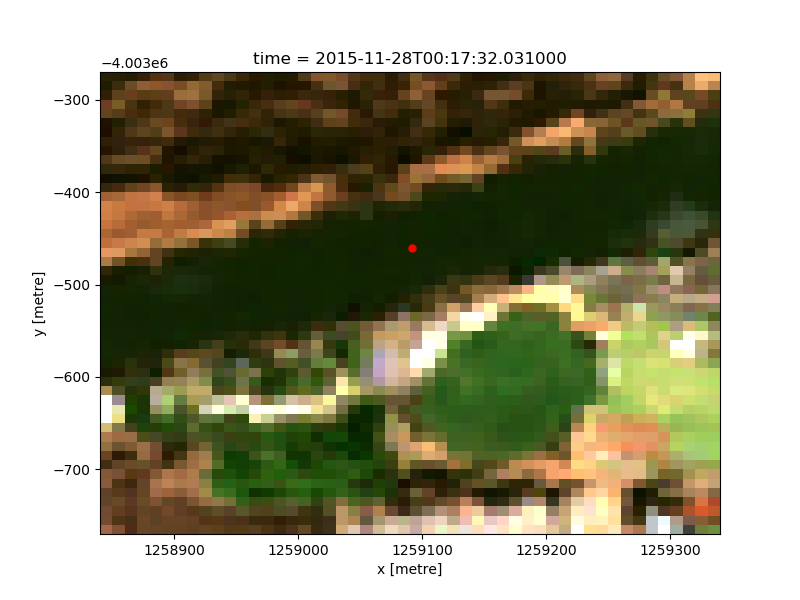

HTML(value='Click on the pixel you would like to interrogate')

In [61]:
print('\033[1m' + 'Click on the pixel you would like to interrogate' + '\033[0m')

#DEAPlotting.rgb(Yarrawonga, bands=['nbar_red', 'nbar_green', 'nbar_blue'], index=2)
DEAPlotting.rgb(Yarrawonga, bands = ['nbar_red', 'nbar_green', 'nbar_blue'],
                             index = mytime)

fig = plt.gcf()
w = widgets.HTML("Click on the pixel you would like to interrogate")

cid = fig.canvas.mpl_connect('button_press_event', onclick)
display(w)


<IPython.core.display.Javascript object>


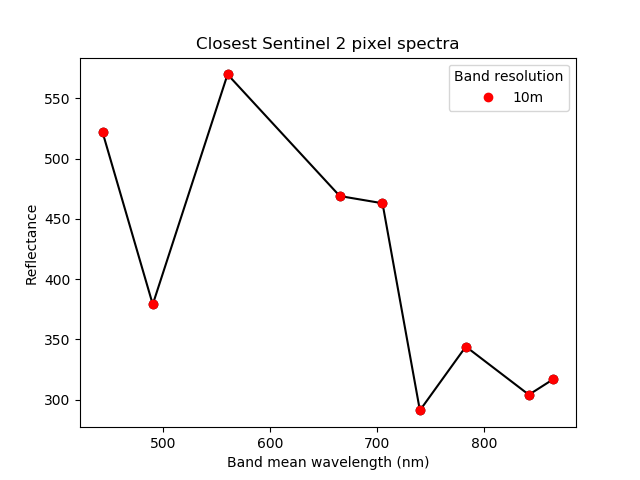

In [62]:
# fig = plt.figure()

# plt.plot(wavelengths, spectra, 'ko-', label='_nolegend_')
# plt.plot((list(wavelengths[i] for i in [0, 1, 2, 3, 4])),
#          (list(spectra[i] for i in [0, 1, 2, 3, 4])), 'ro')

# plt.xlabel('Band mean wavelength (nm)')
# plt.ylabel('Reflectance')
# plt.legend(['10m'], title='Band resolution')
# plt.title('Closest Sentinel 2 pixel spectra');

fig = plt.figure()

plt.plot(wavelengths, spectra, 'ko-', label='_nolegend_')
plt.plot((list(wavelengths[i] for i in [0, 1, 2, 3, 4, 5, 6, 7, 8])),
         (list(spectra[i] for i in [0, 1, 2, 3, 4, 5, 6, 7, 8])), 'ro')


plt.xlabel('Band mean wavelength (nm)')
plt.ylabel('Reflectance')
plt.legend(['10m', '20m', '60m'], title='Band resolution')
plt.title('Closest Sentinel 2 pixel spectra');

<IPython.core.display.Javascript object>


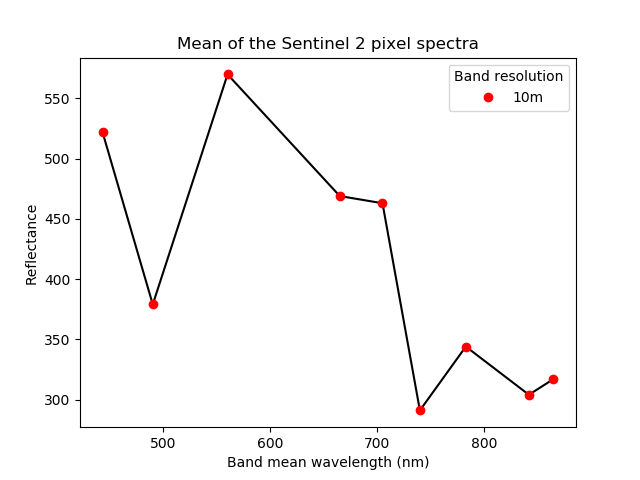

In [64]:
fig = plt.figure()
plt.errorbar(wavelengths, spectramean,
             yerr = [[i - j for i, j in zip(spectramean, spectramin)],
                     [j - i for i, j in zip(spectramean, spectramax)]], color = 'k', linestyle = '-', zorder = 1)
plt.plot((list(wavelengths[i] for i in [0, 1, 2, 3, 4, 5, 6, 7, 8])),
         (list(spectramean[i] for i in [0, 1, 2, 3, 4, 5, 6, 7, 8])), 'ro', zorder = 2)


plt.xlabel('Band mean wavelength (nm)')
plt.ylabel('Reflectance')
plt.legend(['10m'], title='Band resolution')
plt.title('Mean of the Sentinel 2 pixel spectra');

In [82]:
## extra on-click code
%pylab notebook

from datacube import Datacube
import pandas as pd

# Import widgets for interactive notebook
from ipywidgets import interact, fixed
import ipywidgets as widgets

# Import the custom script for plotting. This script can be found in the dea-notebooks repository.
import sys
import os.path
sys.path.append(os.path.expanduser('~/dea-notebooks/10_Scripts'))
#sys.path.append('../10_Scripts/') ### uncomment this line if you have cloned dea-notebooks somewhere other than your user directory

import DEAPlotting

dc = Datacube(app='pixel_drill')

Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


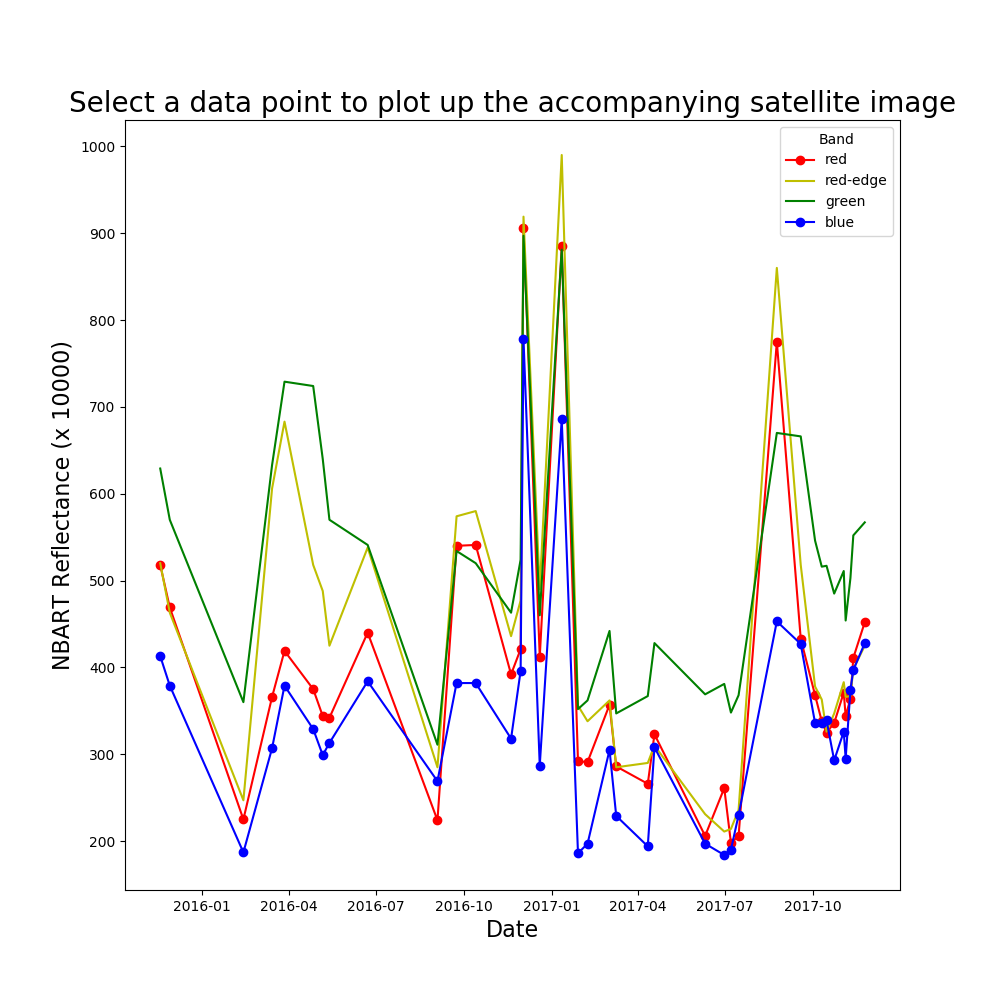

HTML(value='Click on the time you would like to display')

In [76]:
fig = plt.figure(figsize=[10, 10])

plt.plot(Yarrawonga.time, Yarrawonga.nbar_red.sel(
    y=pixely, x=pixelx, method='nearest'), 'ro-',Yarrawonga.time, Yarrawonga.nbar_red_edge_1.sel(
    y=pixely, x=pixelx, method='nearest'), 'y-',Yarrawonga.time, Yarrawonga.nbar_green.sel(
    y=pixely, x=pixelx, method='nearest'), 'g-',Yarrawonga.time, Yarrawonga.nbar_blue.sel(
    y=pixely, x=pixelx, method='nearest'), 'bo-')
plt.xlabel('Date', fontsize=16)
plt.ylabel('NBART Reflectance (x 10000)', fontsize=16)
plt.legend(['red','red-edge','green','blue'], title='Band')
plt.title(
    'Select a data point to plot up the accompanying satellite image', fontsize=20)

w = widgets.HTML("Click on the time you would like to display")


def onclick(event):
    global timeOfInterest
    timeOfInterest = event.xdata
    w.value = 'time of interest : {}'.format(timeOfInterest)


cid = fig.canvas.mpl_connect('button_press_event', onclick)
display(w)

In [77]:
import pandas as pd
# Convert clicked int to datetime format
time_slice = matplotlib.dates.num2date(timeOfInterest).date()
# Convert clicked value to str
time_slice = str(time_slice)
# Convert clicked value to correct datetime format
time_slice = pd.to_datetime(time_slice, format='%Y-%m-%d')
time_slice

Timestamp('2016-11-30 00:00:00')

### Conversion to the Chlorophyll Concentration

**Identify the different equations**

*From Arnold* - Chl=0.5*(B3+B5)-B4

In [78]:
%pyplot
from math import exp
import numpy as np
# redY=Yarrawonga['nbart_red'][0,:,:]
# greenY=Yarrawonga['nbart_green'][0,:,:]

nbar_green_band=Yarrawonga['nbar_green'][:,:,:]
nbar_red_band=Yarrawonga['nbar_red'][:,:,:]
nbar_redEdge_band=Yarrawonga['nbar_red_edge_1'][:,:,:]
#nbar_redEdge_band

In [79]:
Chl=(0.5*(nbar_green_band+nbar_redEdge_band)-(nbar_red_band))
Yarrawonga['Chl'] = Chl

In [80]:
ratio=(0.35*(nbar_green_band/nbar_red_band))
exp=np.exp(ratio)
Chl_fromViet=0.80*(exp)
Yarrawonga['Chl_fromViet']= Chl_fromViet

<IPython.core.display.Javascript object>


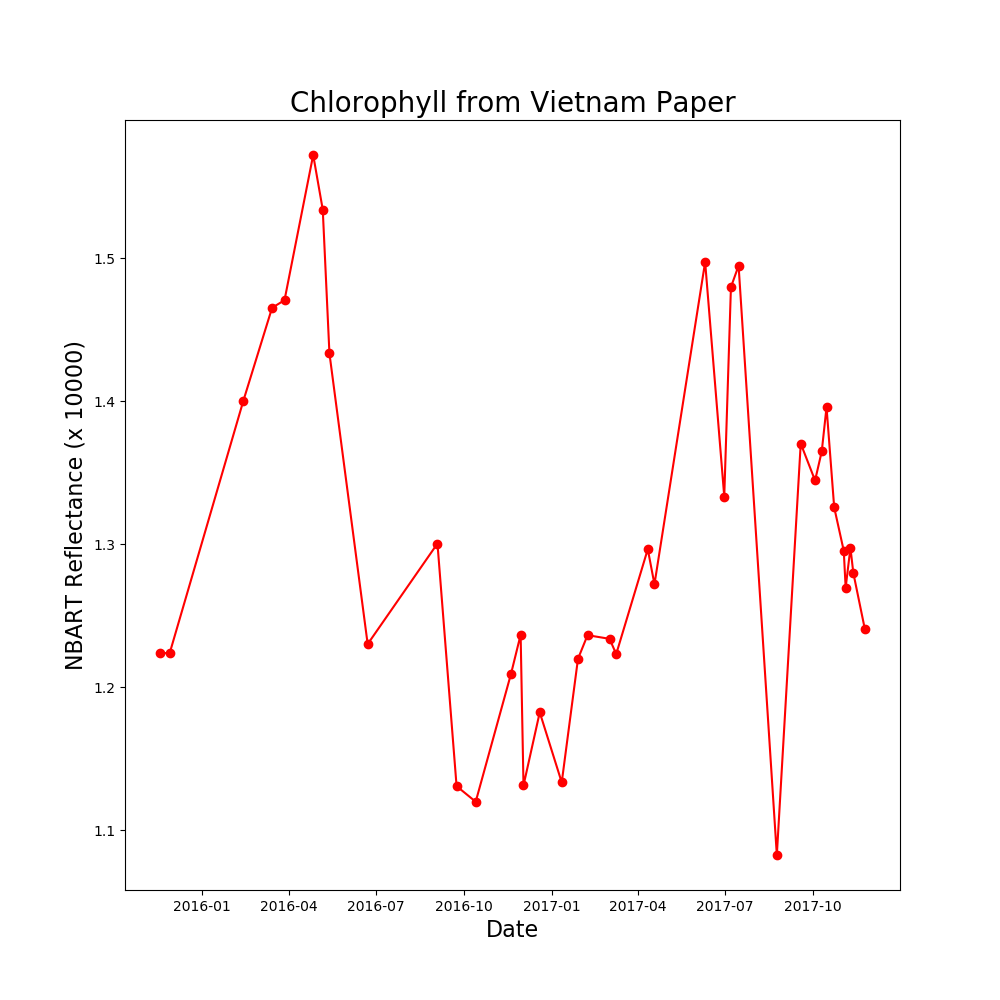

HTML(value='Click on the time you would like to display')

In [83]:
fig = plt.figure(figsize=[10, 10])

plt.plot(Yarrawonga.time, Yarrawonga.Chl_fromViet.sel(
    y=pixely, x=pixelx, method='nearest'), 'ro-')
plt.xlabel('Date', fontsize=16)
plt.ylabel('NBART Reflectance (x 10000)', fontsize=16)
plt.title(
    'Chlorophyll from Vietnam Paper', fontsize=20)

w = widgets.HTML("Click on the time you would like to display")


def onclick(event):
    global timeOfInterest
    timeOfInterest = event.xdata
    w.value = 'time of interest : {}'.format(timeOfInterest)


cid = fig.canvas.mpl_connect('button_press_event', onclick)
display(w)

<IPython.core.display.Javascript object>


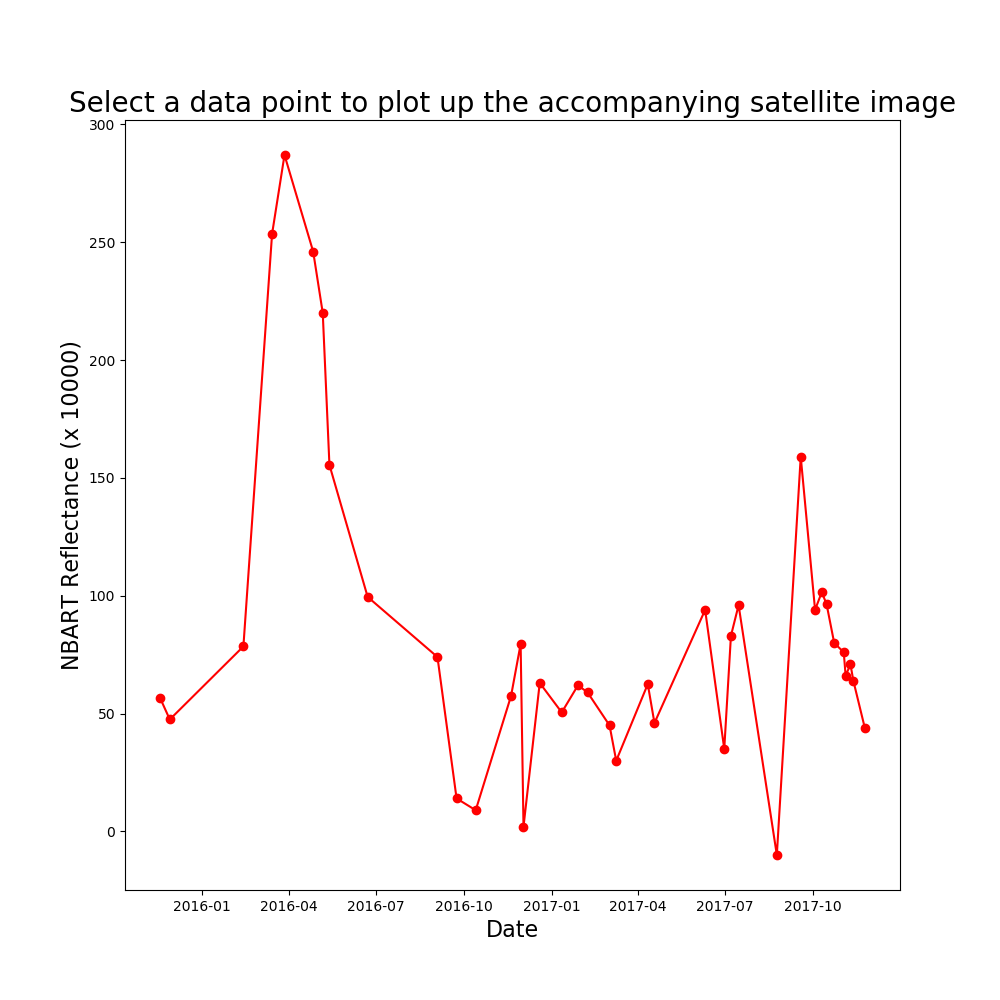

HTML(value='Click on the time you would like to display')

In [84]:
fig = plt.figure(figsize=[10, 10])

plt.plot(Yarrawonga.time, Yarrawonga.Chl.sel(
    y=pixely, x=pixelx, method='nearest'), 'ro-')
plt.xlabel('Date', fontsize=16)
plt.ylabel('NBART Reflectance (x 10000)', fontsize=16)
plt.title(
    'Select a data point to plot up the accompanying satellite image', fontsize=20)

w = widgets.HTML("Click on the time you would like to display")


def onclick(event):
    global timeOfInterest
    timeOfInterest = event.xdata
    w.value = 'time of interest : {}'.format(timeOfInterest)


cid = fig.canvas.mpl_connect('button_press_event', onclick)
display(w)

In [89]:
import pandas as pd
# Convert clicked int to datetime format
time_slice = matplotlib.dates.num2date(timeOfInterest).date()
# Convert clicked value to str
time_slice = str(time_slice)
# Convert clicked value to correct datetime format
time_slice = pd.to_datetime(time_slice, format='%Y-%m-%d')
time_slice

Timestamp('2016-11-19 00:00:00')

/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `three_band_image` has been retired and is no longer supported. Please use the updated `rgb` function from `DEAPlotting.py` instead.
  from ipykernel import kernelapp as app


<IPython.core.display.Javascript object>


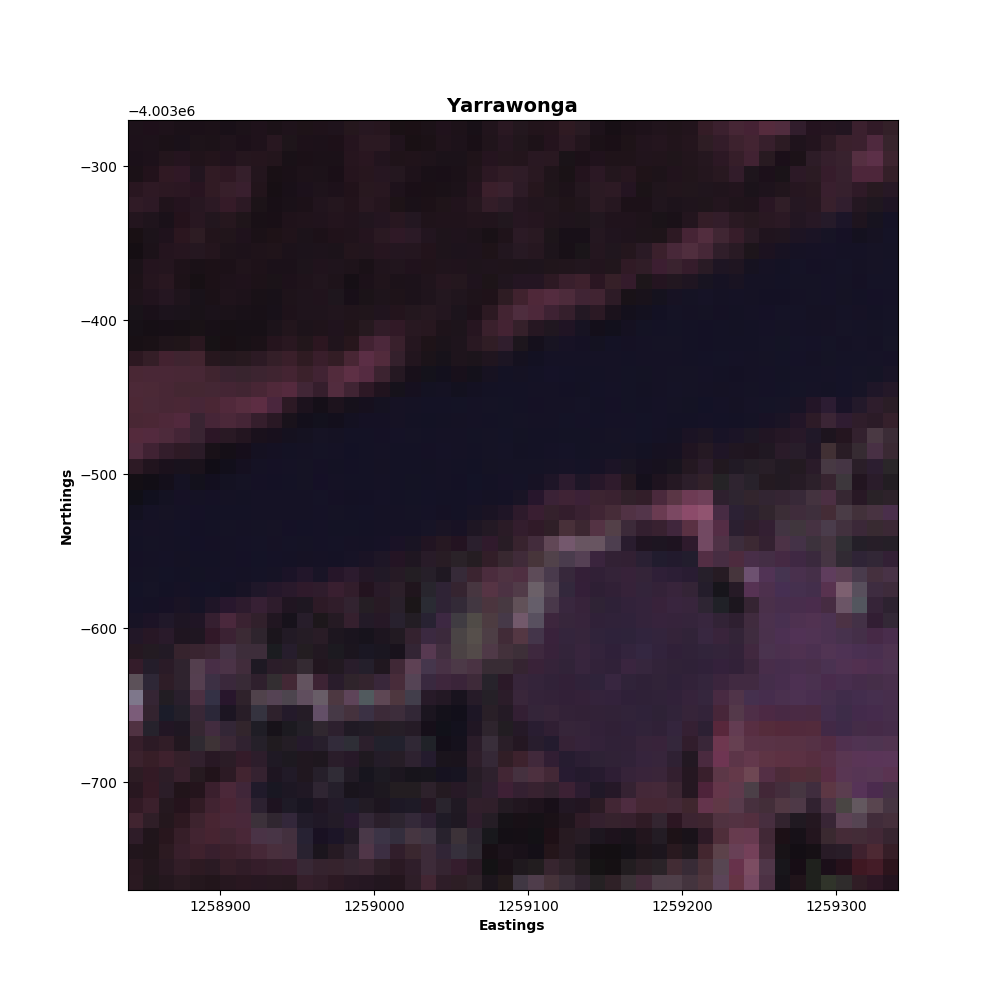

In [87]:
DEAPlotting.three_band_image(Yarrawonga.sel(time=time_slice, method='nearest'), bands=['nbar_red', 'nbar_blue', 'nbar_green'],
                             title='Yarrawonga');
